In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pickle

In [ ]:
from ds_sales_modules import SalesModelData
from ds_sales_modules import TreeBoostedSalesModel
from ds_sales_modules import (XGboostStrategy)
from ds_sales_modules import LoggerModelsResults
from ds_sales_modules import GoodsPredictStrategy

In [4]:
VALIDATION_SIZE = 15+1
TEST_SIZE = 15
GAP = 1
# CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP, TEST_SIZE+60+GAP, TEST_SIZE+90+GAP]
CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP]
CHUNKS = len(CROSVAL_LIST)
FEATURES_BLOCKS_QUANTITY_XGBOOST = 2 #cant be more then 2
OPTUNA_TRIALS_XGBOOST = 10
ROLLING_WINDOW = [7, 30, 60]

models_results_logs = LoggerModelsResults()

In [5]:
df = SalesModelData()
df = df.get_data(period=True, translit=True, left_lim='2023-01-01', right_lim='2024-12-31')
print(f'df size: rows {len(df)} columns {len(df.columns)}')

df size: rows 40325 columns 21


In [6]:
xgboost_model = TreeBoostedSalesModel(df=df,
                                      model_strategy=XGboostStrategy(),
                                      train_test_split_strategy=GoodsPredictStrategy(df=df, rolling_windows=ROLLING_WINDOW), 
                                      num_features_blocks=FEATURES_BLOCKS_QUANTITY_XGBOOST,
                                      logs=models_results_logs)

In [7]:
#hot-fix, need to refactor later
#--------
xgboost_model.feature_test_size = 'goods_model'
#--------

xgboost_model.main_loop_with_cv(chunks=CHUNKS,
                                validation_size=VALIDATION_SIZE,
                                cv_offset_list=CROSVAL_LIST)

Nothing new to merge


In [8]:
xgboost_model.set_results_table()
xgboost_model.models_results.head(10)

Worst MSE 483.9847856473813
Best  MSE 479.259560119472
Worst time 1468.354 seconds
Best  time 778.644 seconds


,set_onehot_dummy_features,MSE,params_num,fit_time
0,0,479.259560,6,778.644
1,1,483.984786,13,1468.354


In [9]:
xgboost_model.select_top_model_vec(top_mse = 3, top_fit_time = 1)
xgboost_model.selected_model_combination

Nothing new to merge


['0']

In [10]:
#In this model it is to long step for only reason to know default_mse
#also it is strangly long in comparison with .get_best_model_pred_on_test(). need to check
# mse_day, _, _ = xgboost_model._train_tree(data=xgboost_model.selected_data_for_best_model, 
#                                           cross_validation=False, 
#                                           logs=False, 
#                                           validation_size=TEST_SIZE+1, 
#                                           params=None)
# print(f'MSE default_XGBRegressor day prediction: {mse_day}')

In [11]:
# xgboost_model._manually_set_top_model_vec(['1'])
# xgboost_model._manually_set_top_model_vec(['0'])
# xgboost_model._manually_set_top_model_vec(['0', '0', '0', '0', '1', '1', '0'])
# xgboost_model._manually_set_top_model_vec(['0', '0', '1', '0', '1', '1', '0'])

In [12]:
xgboost_model.selected_data_for_best_model

,created_day,created_week,created_month,created_year,day,sum
0,2023-01-05,1,1,2023,5,45460.0
1,2023-01-08,1,1,2023,8,39820.0
2,2023-01-10,2,1,2023,10,61818.0
3,2023-01-11,2,1,2023,11,85950.0
4,2023-01-12,2,1,2023,12,419775.0
...,...,...,...,...,...,...
600,2024-09-12,37,9,2024,12,336501.0
601,2024-09-13,37,9,2024,13,842998.0
602,2024-09-15,37,9,2024,15,2680.0
603,2024-09-16,38,9,2024,16,531257.0


In [13]:
best_params = xgboost_model.start_optuna(data=xgboost_model.selected_data_for_best_model, n_trials=OPTUNA_TRIALS_XGBOOST)

[I 2024-09-17 17:32:03,875] A new study created in memory with name: no-name-50658b2e-0f5a-4811-a67c-200d6256dc4c
[I 2024-09-17 17:50:28,627] Trial 0 finished with value: -646.4422627698459 and parameters: {'max_depth': 2, 'learning_rate': 0.19665746044002158, 'n_estimators': 192, 'gamma': 0.18002641643854667, 'subsample': 0.9854100670950483, 'colsample_bytree': 0.8759041386992645, 'reg_alpha': 0.14686169065339588, 'reg_lambda': 0.7757536279448267}. Best is trial 0 with value: -646.4422627698459.


Лучшие параметры: {'max_depth': 2, 'learning_rate': 0.19665746044002158, 'n_estimators': 192, 'gamma': 0.18002641643854667, 'subsample': 0.9854100670950483, 'colsample_bytree': 0.8759041386992645, 'reg_alpha': 0.14686169065339588, 'reg_lambda': 0.7757536279448267}
Лучший результат XGB VAL (MSE): 6.46E+02


In [14]:
y_train, y_test, y_pred, mse = xgboost_model.get_best_model_pred_on_test(test_size=TEST_SIZE+1)

MSE for day prediction with best XGB model: 777.4973634418075


<Axes: >

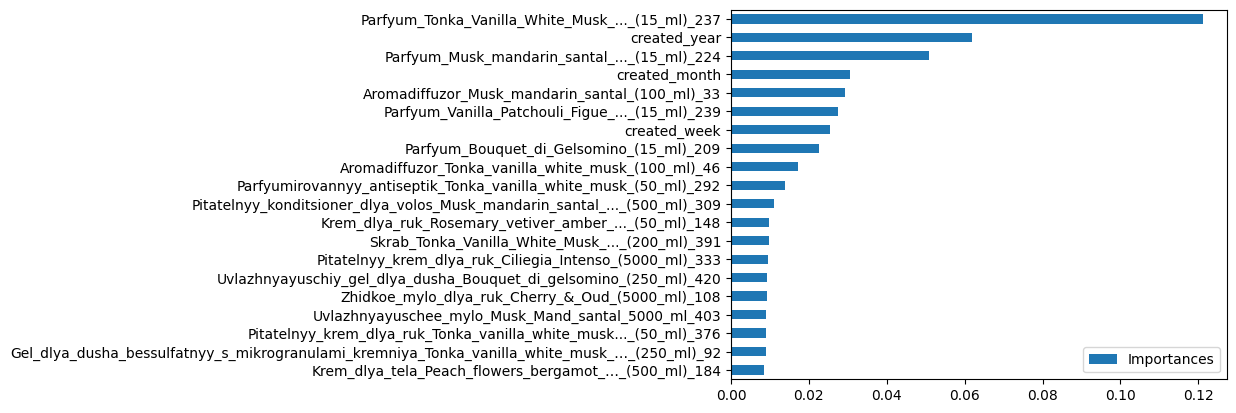

In [15]:
fi = pd.DataFrame(data=xgboost_model.best_cv_model.feature_importances_, index=xgboost_model.best_cv_model.feature_names_in_, columns=['Importances'])
fi.sort_values('Importances', ascending=True)[-20:].plot(kind='barh')

In [16]:
_, margin_of_error = xgboost_model._train_tree(data=xgboost_model.selected_data_for_best_model, 
                                               cross_validation=True, 
                                               chunks=CHUNKS, 
                                               validation_size=VALIDATION_SIZE, 
                                               cv_offset_list = CROSVAL_LIST, 
                                               params=best_params)
lower_bound, upper_bound = xgboost_model.calculate_low_up_bounds(y_pred, margin_of_error, y_test.index)

In [17]:
margin_of_error

Body_care_set_Musk_mandarin_santal_..._6_sum_7_days                                      20.841812
Body_care_set_Rosemary_vetiver_amber_..._7_sum_7_days                                    20.115859
Body_care_set_Tonka_vanilla_white_musk_..._8_sum_7_days                                  19.675306
Hair_care_set_Musk_mandarin_santal_..._9_sum_7_days                                      17.233188
Hair_care_set_Rosemary_vetiver_amber_..._10_sum_7_days                                   13.809182
                                                                                           ...    
Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(5000_ml)_470_sum_60_days                 0.066787
Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(50_ml)_471_sum_60_days            4.952242
Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(500_ml)_472_sum_60_days          21.555597
Shampun_dlya_normalnyh_volos_bessulfatnyy_Grapefruit_&_Santal_(50_ml)_473_sum_60_days    14.569647
Shampun_dl

In [18]:
models_results_logs.all_models_parametrs

,MSE_crossval,MSE_test,best_params,features_vec
XGBoost,6.46E+02,7.77E+02,"{'max_depth': 2, 'learning_rate': 0.1966574604...",['0']


Save model
----------

In [19]:

file_name = "sales_multi_goods_7_30-60.pkl"

# save
pickle.dump(xgboost_model.best_cv_model, open(file_name, "wb"))

Save predictions
--------


In [20]:
xgboost_model._predict_on_last_period(), len(xgboost_model._predict_on_last_period()[0])

(array([[ 2.6193707,  1.7248517,  1.48445  , ..., 66.27652  , 27.447721 ,
         12.784403 ]], dtype=float32),
 1407)

In [21]:
preds = pd.DataFrame(columns=y_train.columns, data=xgboost_model._predict_on_last_period())
preds

,Body_care_set_Musk_mandarin_santal_..._6_sum_7_days,Body_care_set_Rosemary_vetiver_amber_..._7_sum_7_days,Body_care_set_Tonka_vanilla_white_musk_..._8_sum_7_days,Hair_care_set_Musk_mandarin_santal_..._9_sum_7_days,Hair_care_set_Rosemary_vetiver_amber_..._10_sum_7_days,Hair_care_set_Tonka_vanilla_white_musk_..._11_sum_7_days,Hand_care_set_Musk_mandarin_santal_..._12_sum_7_days,Hand_care_set_Rosemary_vetiver_amber_..._13_sum_7_days,Hand_care_set_Tonka_vanilla_white_musk_..._14_sum_7_days,Aromadiffuzor_Amber_dream_(100_ml)_15_sum_7_days,...,Shampun_dlya_normalnyh_volos_Grapefruit_&_Santal_(5000_ml)_465_sum_60_days,Shampun_dlya_normalnyh_volos_Jasmine_&_Cassis_(250_ml)_466_sum_60_days,Shampun_dlya_normalnyh_volos_Jasmine_&_Cassis_(500_ml)_467_sum_60_days,Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(250_ml)_468_sum_60_days,Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(500_ml)_469_sum_60_days,Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(5000_ml)_470_sum_60_days,Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(50_ml)_471_sum_60_days,Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(500_ml)_472_sum_60_days,Shampun_dlya_normalnyh_volos_bessulfatnyy_Grapefruit_&_Santal_(50_ml)_473_sum_60_days,Shampun_dlya_normalnyh_volos_bessulfatnyy_Oud_&_Black_pepper_(50_ml)_474_sum_60_days
0,2.619371,1.724852,1.48445,1.923569,3.849622,2.433256,3.479694,3.109496,2.457119,5.30574,...,-1.027621,-0.53094,-0.978936,-18.167536,41.372318,-0.129069,63.680767,66.27652,27.447721,12.784403


In [22]:
file_name_prediction = "sales_multi_goods_7_30-60_predictions.pkl"
preds = pd.DataFrame(columns=y_train.columns, data=xgboost_model._predict_on_last_period())

In [23]:
preds_7 = preds.iloc[:, preds.columns.str.contains('7_days')]
preds_7 = preds_7.T
preds_7.columns = ['7_preds']
preds_7.index = preds_7.index.str.replace(r'_\d+_sum_\d+_days$', '', regex=True)

preds_30 = preds.iloc[:, preds.columns.str.contains('30_days')]
preds_30 = preds_30.T
preds_30.columns = ['30_preds']
preds_30.index = preds_30.index.str.replace(r'_\d+_sum_\d+_days$', '', regex=True)

preds_60 = preds.iloc[:, preds.columns.str.contains('60_days')]
preds_60 = preds_60.T
preds_60.columns = ['60_preds']
preds_60.index = preds_60.index.str.replace(r'_\d+_sum_\d+_days$', '', regex=True)

In [24]:
# preds_all = pd.concat([preds_7, preds_30, preds_60], axis=0)
preds_all = pd.concat([preds_7, preds_30, preds_60], axis=1)

In [25]:
preds_all

,7_preds,30_preds,60_preds
Body_care_set_Musk_mandarin_santal_...,2.619371,13.725945,15.835909
Body_care_set_Rosemary_vetiver_amber_...,1.724852,9.776658,14.969533
Body_care_set_Tonka_vanilla_white_musk_...,1.484450,6.912789,13.730696
Hair_care_set_Musk_mandarin_santal_...,1.923569,9.154207,16.174612
Hair_care_set_Rosemary_vetiver_amber_...,3.849622,17.495764,31.634666
...,...,...,...
Shampun_dlya_normalnyh_volos_Oud_&_Black_pepper_(5000_ml),0.005357,-0.066290,-0.129069
Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(50_ml),7.885705,31.026674,63.680767
Shampun_dlya_normalnyh_volos_bessulfatnyy_Cherry_&_Oud_(500_ml),6.885270,21.930464,66.276520
Shampun_dlya_normalnyh_volos_bessulfatnyy_Grapefruit_&_Santal_(50_ml),3.482336,14.855224,27.447721


In [26]:
preds_all.to_pickle(file_name_prediction)